## Табличное Q-обучение


Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686">


<!-- Раскроем скобки:
$$Q(s,a)\leftarrow (1 - \alpha) \times Q(s,a)+\alpha \times \big (r(s)+\gamma\max_{a'}Q(a',s')\big ).$$ -->

Для обучения будем использовать среду Taxi-v3. Подробнее про данное окружение можно посмотреть в документации: https://gymnasium.farama.org/environments/toy_text/taxi/.

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

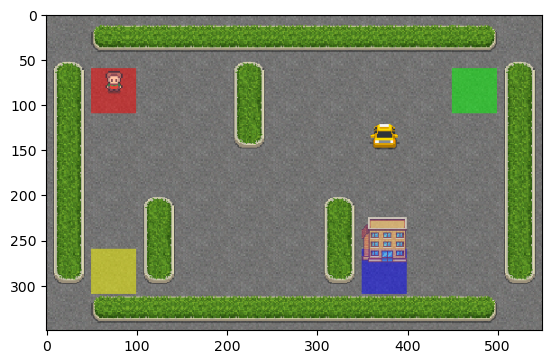

In [3]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [4]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

### Задание 1

Создайте таблицу из нулей, используя информацию из окружения о количестве состояний и действий (1 балл)

In [5]:
def initialize_q_table(n_observation_space, n_action_space):
    # Q = [state][action]
    ####### Здесь ваш код ########
    Q = np.zeros((n_observation_space, n_action_space))
    ##############################
    return Q

In [6]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

### Задание 2

Напишите код для epsilon-жадного выбора действия (1 балл):

In [7]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    # action =
    ####### Здесь ваш код ########
    if np.random.rand() < epsilon:
        action = np.random.randint(0, len(Q[state]))
    else:
        action = np.argmax(Q[state])
    ##############################
    return action

Напишите код для формулы Q-обновления (1 балл):

In [8]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # alpha: learning rate, gamma: discount factor
    # вычисли V(next_s) - estimate of optimal future value
    # V_ns =
    ####### Здесь ваш код ########
    V_ns = np.max(Q[next_s])
    ##############################

    # посчитай TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * V_ns - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации Q-обучения (2 балла):

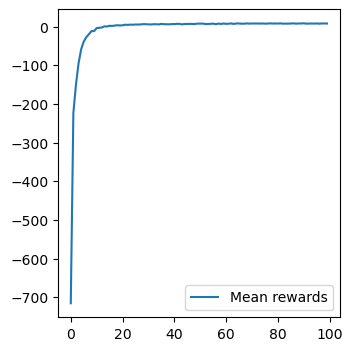

Episode: 10000, Reward: 8, Eps: 0.001246427204280841


In [9]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
n_episodes = 10000

for i_episode in range(1, n_episodes + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        # a = ...
        ####### Здесь ваш код ########
        a = select_action_eps_greedy(Q, s, epsilon)
        ##############################

        # выполняем действие в среде
        next_s, r, terminated, truncated, _ = env.step(a)

        # Update Q-function
        ####### Здесь ваш код ########
        update_Q(Q, s, a, r, next_s, alpha, gamma)
        ##############################

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if i_episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(
            f"Episode: {i_episode}, Reward: {episode_reward}"
            f", Eps: {epsilon}"
        )
        epsilon *= epsilon_decay

assert log[-1] >= -10

### Интерпретация результатов (1 балл):
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

In [10]:
def train(update_function, alpha, gamma, epsilon, epsilon_decay, n_episodes):
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []

    for i_episode in range(1, n_episodes + 1):
        s, _ = env.reset()
        terminated = False
        episode_reward = 0

        while not terminated:
            a = select_action_eps_greedy(Q, s, epsilon)
            next_s, r, terminated, truncated, _ = env.step(a)

            try:
                update_function(Q, s, a, r, next_s, alpha, gamma)
            except:
                update_function(Q, s, a, r, next_s, alpha, gamma, epsilon)

            s = next_s
            episode_reward += r

        rewards_batch.append(episode_reward)

        if i_episode % 100 == 0:
            log.append(np.mean(rewards_batch))
            rewards_batch = []
            epsilon *= epsilon_decay

    return np.array(log)

In [11]:
def compare_params(param_configs, n_episodes, update_function):
    plt.figure(figsize=(14, 10))

    for plot_id, (param_name, values) in enumerate(param_configs.items()):
        plt.subplot(2, 2, plot_id + 1)
        
        for value in values:
            alpha = 0.1
            gamma = 0.9
            epsilon = 0.2
            epsilon_decay = 0.95
    
            if param_name == "alpha":
                alpha = value
            elif param_name == "gamma":
                gamma = value
            elif param_name == "epsilon":
                epsilon = value
            elif param_name == "epsilon_decay":
                epsilon_decay = value
    
            log = train(update_function, alpha, gamma, epsilon, epsilon_decay, n_episodes)
            plt.plot(np.arange(1, len(log) + 1) * 100, np.abs(log - 20), label=f"{param_name}={value:.2f}")
        
        plt.yscale("log")
        plt.xlabel("Episode")
        plt.ylabel("Log(|reward - 20|)")
        plt.title(f"Effect of {param_name}")
        plt.legend()
        plt.grid(True, which="both", linestyle=":")
        plot_id += 1
    
    plt.tight_layout()
    plt.show()

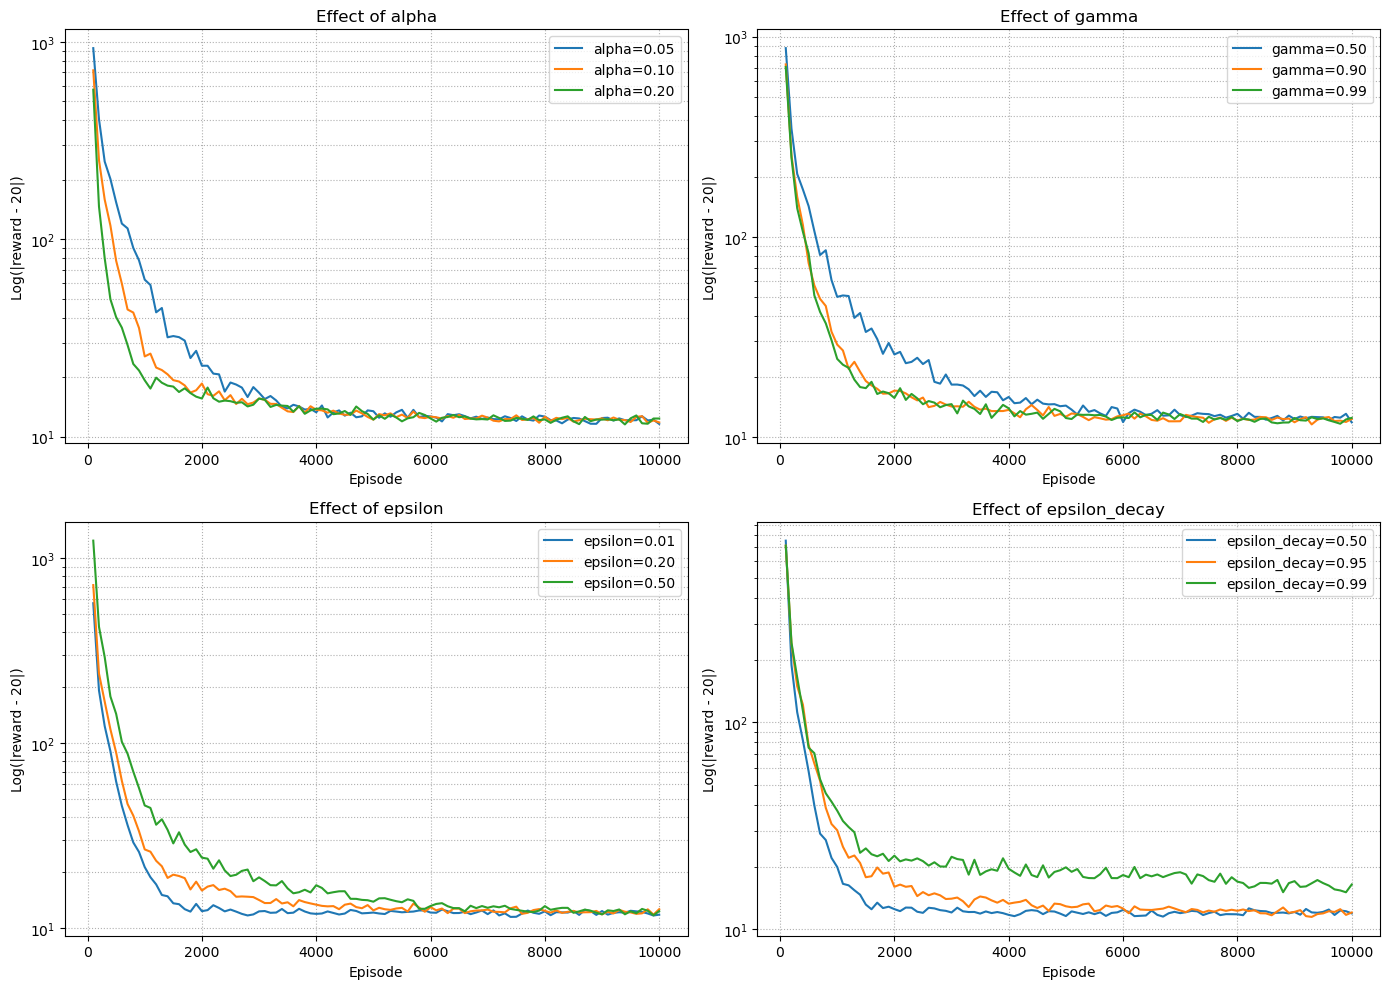

In [12]:
param_configs = {
    "alpha": [0.05, 0.1, 0.2],
    "gamma": [0.5, 0.9, 0.99],
    "epsilon": [0.01, 0.2, 0.5],
    "epsilon_decay": [0.5, 0.95, 0.99],
}
n_episodes = 10000

compare_params(param_configs, n_episodes, update_Q)

**Выводы:**
1. **alpha** - влияет только на скорость изначальной сходимости. Большее значение ускоряет сходимость.
2. **gamma** - влияет только на скорость изначальной сходимости. Большее значение ускоряет сходимость.
3. **epsilon** - влияет только на скорость изначальной сходимости. Меньшее значение ускоряет сходимость.
4. **epsilon_decay** - слишком большие значения (близкие к 1) могут вызывать проблемы с решением задачи. Меньшие значения ускоряют сходимость.

Вероятно из-за простоты задачи изменение большинства гиперпараметров не повлияет на результат обучения при достаточном числе итераций.

## SARSA

Теперь ради интереса попробуем то же самое, но используя метод SARSA.

Для начала, добавим функцию обновления Q-функции (1 балл):

In [13]:
def update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon):
    # выбери следующее действие eps-greedy
    # next_a =
    ####### Здесь ваш код ########
    next_a = select_action_eps_greedy(Q, next_s, epsilon)
    ##############################

    # посчитай TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * Q[next_s][next_a] - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации SARSA-обучения (2 балла):

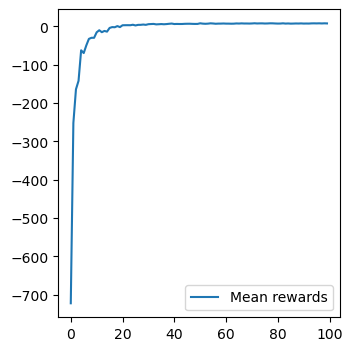

Episode: 10000, Reward: 10, Eps: 0.001246427204280841


In [14]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        # a = ...
        ####### Здесь ваш код ########
        a = select_action_eps_greedy(Q, s, epsilon)
        ##############################

        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)

        # Update Q-function with SARSA
        ####### Здесь ваш код ########
        update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon)
        ##############################

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] >= -10

Сравнивая SARSA и Q-learning, что можно сказать об их кривых обучения? (быстрее-медленнее, обучение стабильнее или нет и тп) (1 балл)

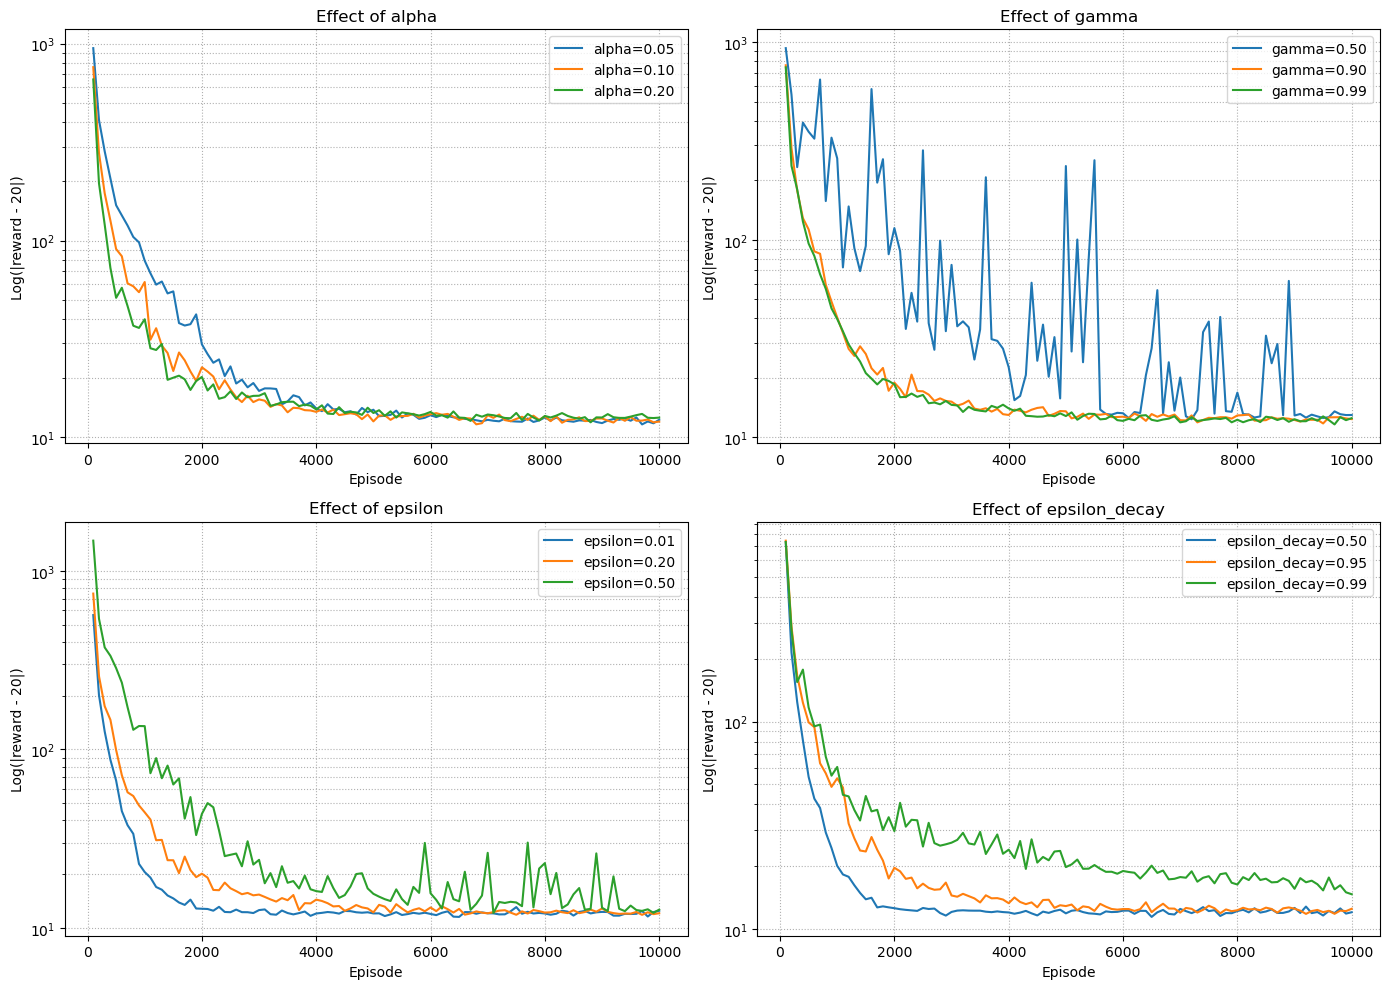

In [15]:
param_configs = {
    "alpha": [0.05, 0.1, 0.2],
    "gamma": [0.5, 0.9, 0.99],
    "epsilon": [0.01, 0.2, 0.5],
    "epsilon_decay": [0.5, 0.95, 0.99],
}
n_episodes = 10000

compare_params(param_configs, n_episodes, update_Q_SARSA)

**Выводы:**
1. Поведение **alpha** и **epsilon_decay** аналогичны алгоритму Q-learning.
2. Маленькие значения **gamma** и большие значения **epsilon** приводят к нестабильности обучения, а не просто к ухудшению сходимости как в Q-learning.

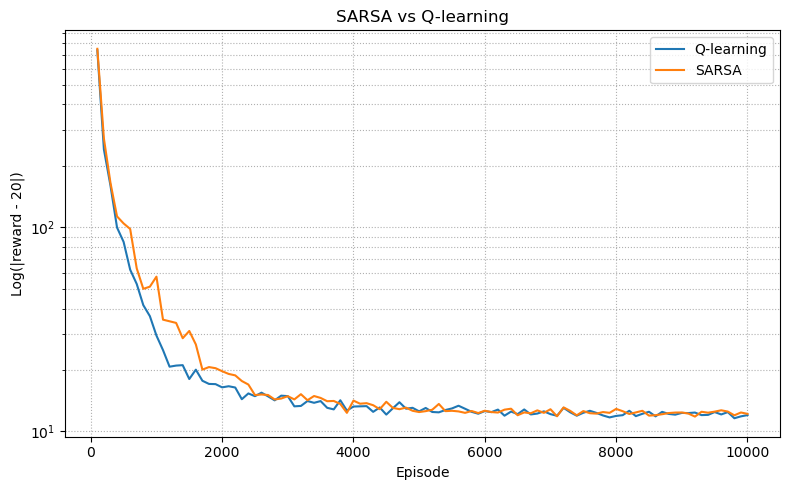

In [16]:
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
n_episodes = 10000

log_q = train(update_Q, alpha, gamma, epsilon, epsilon_decay, n_episodes)
log_sarsa = train(update_Q_SARSA, alpha, gamma, epsilon, epsilon_decay, n_episodes)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(log_q) + 1) * 100, np.abs(log_q - 20), label="Q-learning")
plt.plot(np.arange(1, len(log_sarsa) + 1) * 100, np.abs(log_sarsa - 20), label="SARSA")

plt.yscale("log")
plt.xlabel("Episode")
plt.ylabel("Log(|reward - 20|)")
plt.title("SARSA vs Q-learning")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


**Вывод:**
* алгоритмы SARSA и Q-learning в рамках поставленной задачи выдают одинаковые результаты